## Model Training


#### 1.1 Import Data and Required Packages

##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.


In [100]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

# Sklearn Import
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Other Import
import warnings

#### Import the CSV Data as Pandas DataFrame


In [101]:
# Read Data from CSV File and Store it in Pandas DataFrame Object
df = pd.read_csv("data/insurance.csv")

#### Show Top 5 Records


In [102]:
# Check the first 5 rows of the data
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Preparing X and Y variables


In [103]:
# Features except target variable (charges) are stored in X variable
X = df.drop(columns=["charges"], axis=1)

In [104]:
# Top 5 rows of X variable (features) are displayed below
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [105]:
# Categories in the different dataset variables
print("Categories in 'sex' variable:     ", end=" ")
print(df["sex"].unique())

print("Categories in 'smoker' variable:  ", end=" ")
print(df["smoker"].unique())

print("Categories in'region' variable:", end=" ")
print(df["region"].unique())

print("Categories in 'children' variable:     ", end=" ")
print(df["children"].unique())

Categories in 'sex' variable:      ['female' 'male']
Categories in 'smoker' variable:   ['yes' 'no']
Categories in'region' variable: ['southwest' 'southeast' 'northwest' 'northeast']
Categories in 'children' variable:      [0 1 3 2 5 4]


In [106]:
# Target variable (charges) is stored in y variable
y = df["charges"]

In [107]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [108]:
# define categorical columns
categorical_features = [feature for feature in X.columns if X[feature].dtype == "O"]

# print columns
print(
    f"We have {len(categorical_features)} categorical features : {categorical_features}"
)

We have 3 categorical features : ['sex', 'smoker', 'region']


In [109]:
# define numerical features
numeric_features = [feature for feature in X.columns if X[feature].dtype != "O"]

# print columns
print(f"We have {len(numeric_features)} numerical features : {numeric_features}")

We have 3 numerical features : ['age', 'bmi', 'children']


In [110]:
# Discrete numerical features
discrete_feature = [
    feature for feature in numeric_features if len(X[feature].unique()) < 25
]
print(f"We have {len(discrete_feature)} discrete features : {discrete_feature}")

We have 1 discrete features : ['children']


In [111]:
# Contunious numerical features
continuous_feature = [
    feature for feature in numeric_features if feature not in discrete_feature
]
print(f"We have {len(continuous_feature)} continuous features : {continuous_feature}")

We have 2 continuous features : ['age', 'bmi']


In [112]:
# # Create Column Transformer with 3 types of transformers
# num_features = X.select_dtypes(exclude="object").columns
# cat_features = X.select_dtypes(include="object").columns

# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer

# numeric_transformer = StandardScaler()
# oh_transformer = OneHotEncoder()

# preprocessor = ColumnTransformer(
#     [
#         ("RarelabelEncoder", RareLabelEncoder(), cat_features),
#         ("OrdinalEncoder", OrdinalEncoder(), cat_features),
#         ("Discretizer", EqualFrequencyDiscretiser(), num_features),
#         ("encoding", oh_transformer, cat_features)(
#             "StandardScaler", numeric_transformer, num_features
#         ),
#     ]
# )

In [113]:
# Discrete numerical features are converted to object type for encoding purpose later on in the pipeline
X[discrete_feature] = X[discrete_feature].astype("O")

In [114]:
preprocessor = Pipeline(
    [
        # categorical encoding
        (
            "rare_label_enc",
            ce.RareLabelEncoder(
                tol=0.05,
                n_categories=1,
                variables=categorical_features + discrete_feature,
            ),
        ),
        (
            "categorical_enc",
            ce.OrdinalEncoder(
                encoding_method="ordered",
                variables=categorical_features + discrete_feature,
            ),
        ),
        # discretisation + encoding
        # (
        #     "discretisation",
        #     dsc.EqualFrequencyDiscretiser(
        #         q=5, return_object=True, variables=continuous_feature
        #     ),
        # ),
        # (
        #     "encoding",
        #     ce.OrdinalEncoder(encoding_method="ordered", variables=continuous_feature),
        # ),
        # feature Scaling
        ("scaler", StandardScaler()),
    ]
)

In [115]:
X = preprocessor.fit_transform(X, y)

In [116]:
X.shape

(1338, 6)

In [117]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape

((1070, 6), (268, 6))

#### Create an Evaluate Function to give all metrics after model Training


In [118]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [120]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor(),
    "SVR": SVR(),
}
model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)  # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(
        y_train, y_train_pred
    )

    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print("Model performance for Training set")
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print("----------------------------------")

    print("Model performance for Test set")
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)

    print("=" * 35)
    print("\n")

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 6116.6943
- Mean Absolute Error: 4225.8176
- R2 Score: 0.7408
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5830.7481
- Mean Absolute Error: 4240.5683
- R2 Score: 0.7810


Lasso
Model performance for Training set
- Root Mean Squared Error: 6116.6947
- Mean Absolute Error: 4225.7613
- R2 Score: 0.7408
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5830.7305
- Mean Absolute Error: 4240.4181
- R2 Score: 0.7810


Ridge
Model performance for Training set
- Root Mean Squared Error: 6116.7021
- Mean Absolute Error: 4226.9067
- R2 Score: 0.7408
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5831.2825
- Mean Absolute Error: 4242.1666
- R2 Score: 0.7810


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 4311.3131
- Mean Absolute Error: 2604.3481


CatBoosting Regressor
Model performance for Training set
- Root Mean Squared Error: 2718.3816
- Mean Absolute Error: 1535.7641
- R2 Score: 0.9488
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4637.6257
- Mean Absolute Error: 2673.4862
- R2 Score: 0.8615


AdaBoost Regressor
Model performance for Training set
- Root Mean Squared Error: 5143.2570
- Mean Absolute Error: 4319.8009
- R2 Score: 0.8167
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5401.9409
- Mean Absolute Error: 4574.2264
- R2 Score: 0.8120


SVR
Model performance for Training set
- Root Mean Squared Error: 12560.0403
- Mean Absolute Error: 8243.4042
- R2 Score: -0.0930
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 12879.7131
- Mean Absolute Error: 8601.7048
- R2 Score: -0.0685




### Results


In [121]:
pd.DataFrame(
    list(zip(model_list, r2_list)), columns=["Model Name", "R2_Score"]
).sort_values(by=["R2_Score"], ascending=False)

,Model Name,R2_Score
5,Random Forest Regressor,0.866294
7,CatBoosting Regressor,0.861464
6,XGBRegressor,0.841267
3,K-Neighbors Regressor,0.839822
8,AdaBoost Regressor,0.812037
1,Lasso,0.781013
0,Linear Regression,0.781012
2,Ridge,0.780972
4,Decision Tree,0.704560
9,SVR,-0.068524


## Linear Regression


In [122]:
# lin_model = LinearRegression(fit_intercept=True)
# lin_model = lin_model.fit(X_train, y_train)
# y_pred = lin_model.predict(X_test)
# score = r2_score(y_test, y_pred) * 100
# print(" Accuracy of the model is %.2f" % score)

In [127]:
catboost_model = CatBoostRegressor(verbose=False)
catboost_model = catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
score = r2_score(y_test, y_pred) * 100
print(" Accuracy of the model is %.2f" % score)

,Model Name,R2 Score
5,Random Forest Regressor,0.862088
7,CatBoosting Regressor,0.861464
6,XGBRegressor,0.841267
3,K-Neighbors Regressor,0.839822
8,AdaBoost Regressor,0.832407
1,Lasso,0.781013
0,Linear Regression,0.781012
2,Ridge,0.780972
4,Decision Tree,0.724899
9,SVR,-0.068524


## Plot y_pred and y_test


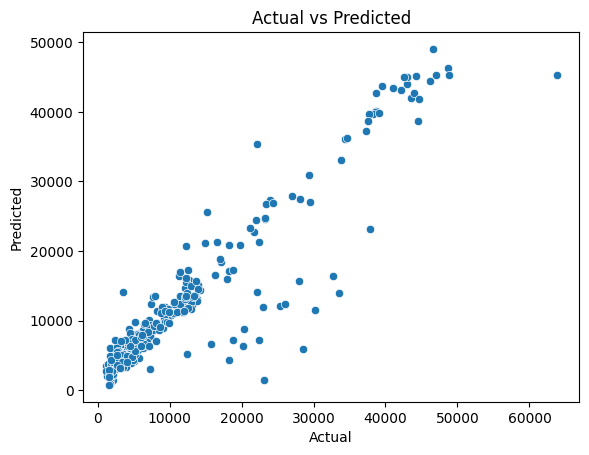

In [124]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

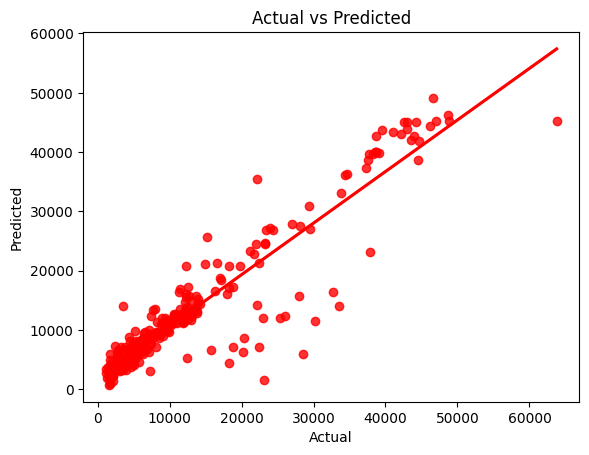

In [125]:
sns.regplot(x=y_test, y=y_pred, ci=None, color="red")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

#### Difference between Actual and Predicted Values


In [126]:
pred_df = pd.DataFrame(
    {"Actual Value": y_test, "Predicted Value": y_pred, "Difference": y_test - y_pred}
)


pred_df

,Actual Value,Predicted Value,Difference
764,9095.06825,11109.360694,-2014.292444
887,5272.17580,8096.183240,-2824.007440
890,29330.98315,30889.338876,-1558.355726
1293,9301.89355,10522.854685,-1220.961135
259,33750.29180,33085.886292,664.405508
...,...,...,...
109,47055.53210,45237.974560,1817.557540
575,12222.89830,13466.558073,-1243.659773
535,6067.12675,6292.641302,-225.514552
543,63770.42801,45312.229833,18458.198177
